# Generative Adversarial Networks (GANs)

__NOTE__: This notebook's cells have been executed, but some code have been removed because it contained answers to the homework, so running it again will raise errors without filling in the removed code specified as `NotImplemented`.

GANs typically consist of a generator $G$ and a discriminator $D$. They are trained in an _adversarial_ setting: the discriminator is trained to discriminate real data from fake data (we call the outputs of the generator fake), while the generator is trained so its output looks more like real data, so the discriminator cannot tell real and fake data apart. Let's try to implement and train a GAN on the MNIST dataset.

In [1]:
from typing import List, Union
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.autolayout': True})
from IPython.display import display, clear_output

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision.transforms import v2

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'
print(f'Device is {Device}')

Device is cpu


In [2]:
train_dataset = datasets.MNIST(
    root = 'MNIST',
    train = True,
    download = True,
    # transform the data to torch.Tensor and scale it to [0, 1]
    transform = v2.Compose([
        # convert to tensor and scale to [0, 1]
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ])
    )

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 102591735.66it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 3237191.18it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 25259008.97it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 3483366.02it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



## Architecture of Generator and Discriminator

In [3]:
class Generator(nn.Module):

    def __init__(
            self,
            latent_size: int = 128,
            output_shape: List[int] = [1, 28, 28],
            hidden_sizes: List[int] = [128, 256, 512, 1024],
            batchnorm: bool = True,
            activation_name: str = 'ReLU',
            ):
        super().__init__()

        activation = getattr(nn, activation_name)
        self.latent_size = latent_size
        output_size = np.prod(output_shape)
        self.layers = nn.Sequential()

        for i in range(len(hidden_sizes)):

            self.layers.append(
                nn.Linear(
                    in_features = latent_size if i == 0 else hidden_sizes[i-1],
                    out_features = hidden_sizes[i],
                    ))

            if batchnorm and i>0:
                self.layers.append(nn.BatchNorm1d(hidden_sizes[i]))

            self.layers.append(activation())

        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers.append(nn.Sigmoid()) # Because the pixel values are in [0, 1]
        self.layers.append(nn.Unflatten(dim=1, unflattened_size=output_shape))

    def forward(
            self, 
            z: torch.FloatTensor, # (batch_size, latent_size)
            ) -> torch.FloatTensor: # (batch_size, *output_shape)
        """
        Input z is the latent vector, typically sampled from N(0, I)
        Outputs generated images
        """
        return self.layers(z)

    def generate(
            self,
            n_samples: int,
            device: str = Device,
            ) -> torch.FloatTensor: # (n_samples, *output_shape)
        self.to(device)
        z = torch.randn(n_samples, self.latent_size, device=device)
        return self(z)


class Discriminator(nn.Module):

    def __init__(
            self,
            input_shape: List[int] = [1, 28, 28],
            hidden_sizes: List[int] = [512, 256],
            activation_name: str = 'ReLU',
            ):
        super().__init__()

        activation = getattr(nn, activation_name)

        input_size = np.prod(input_shape)

        self.layers = nn.Sequential(nn.Flatten())

        for i in range(len(hidden_sizes)):
            
            self.layers.append(
                nn.Linear(
                    in_features = input_size if i == 0 else hidden_sizes[i-1],
                    out_features = hidden_sizes[i],
                    ))

            self.layers.append(activation())

        self.layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.layers.append(nn.Sigmoid()) # Because it is a binary classification (REAL or FAKE)

    def forward(
            self,
            x: torch.FloatTensor, # (batch_size, *input_shape)
            ) -> torch.FloatTensor: # (batch_size, 1)
        
        return self.layers(x)

## Tracking and Visualization

In [4]:
class GAN_Tracker:
    """
    Logs and plots different loss terms of a GAN during training.
    """
    def __init__(
            self, 
            n_iters: int,
            plot_freq: Union[int, None] = None, # plot every plot_freq iterations
            ):
        
        self.real_scores = []
        self.fake_scores = []
        self.D_losses = []
        self.G_losses = []

        self.plot = plot_freq is not None
        self.iter = 0
        self.n_iters = n_iters
		
        if self.plot:
            self.plot_freq = plot_freq
            self.plot_results()


    def plot_results(self):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(13, 3), sharex=True)

        # Score plot:
        self.real_score_curve, = self.ax1.plot(
            range(1, self.iter+1),
            self.real_scores,
			label = r'$D(x)$',
            )
        self.fake_score_curve, = self.ax1.plot(
            range(1, self.iter+1),
            self.fake_scores,
            label = r'$D(G(z))$',
            )

        self.ax1.set_xlim(0, self.n_iters+1)
        self.ax1.set_ylim(0, 1)
        self.ax1.set_xlabel('Iteration')
        self.ax1.set_ylabel('Discriminator Score')
        self.ax1.set_title('Discriminator Score')
        self.ax1.grid(linestyle='--')
        self.ax1.legend()

        # Loss plot:
        self.D_loss_curve, = self.ax2.plot(
            range(1, self.iter+1),
            self.D_losses,
			label = 'D',
            )
        self.G_loss_curve, = self.ax2.plot(
            range(1, self.iter+1),
            self.G_losses,
            label = 'G',
            )
        self.ax2.set_xlim(0, self.n_iters+1)
        self.ax2.set_xlabel('Iteration')
        self.ax2.set_ylabel('Loss')
        self.ax2.set_title('Learning Curve')
        self.ax2.grid(linestyle='--')
        self.ax2.legend()

        self.samples_fig, self.samples_axes = plt.subplots(4, 15, figsize=(12, 4), sharex=True, sharey=True)
        self.sample_axes = self.samples_axes.flat
        self.samples = []
        for ax in self.sample_axes:
            ax.axis('off')
            self.samples.append(ax.imshow(np.zeros((28, 28)), cmap='gray', vmin=0, vmax=1))


    def update(
            self, 
            real_score: float,
            fake_score: float,
            D_loss: float,
            G_loss: float,
            ):
        self.real_scores.append(real_score)
        self.fake_scores.append(fake_score)
        self.D_losses.append(D_loss)
        self.G_losses.append(G_loss)
        self.iter += 1
		
        if self.plot and self.iter % self.plot_freq == 0:

            # score plot:
            self.real_score_curve.set_data(range(1, self.iter+1), self.real_scores)
            self.fake_score_curve.set_data(range(1, self.iter+1), self.fake_scores)
            self.ax1.relim()
            self.ax1.autoscale_view()

            # loss plot:
            self.D_loss_curve.set_data(range(1, self.iter+1), self.D_losses)
            self.G_loss_curve.set_data(range(1, self.iter+1), self.G_losses)
            self.ax2.relim()
            self.ax2.autoscale_view()

            self.samples_fig.suptitle(f'Generated Samples at Iteration {self.iter}')

            self.fig.canvas.draw()
            clear_output(wait=True)
            display(self.fig)
            display(self.samples_fig)

    
    def get_samples(
            self, 
            samples: torch.FloatTensor, # (n_samples, *output_shape)
            ):
        for sample, sample_img in zip(samples, self.samples):
            sample_img.set_data(sample.detach().squeeze().cpu().numpy())
            

## Losses 

Hint: use `F.binary_cross_entropy(input, target)` with the right input and target for each loss function.

In [ ]:
def D_real_loss_fn(
        D_real: torch.FloatTensor, # (batch_size, 1)
        ) -> torch.FloatTensor: # ()
    """
    D_real is D(x), the discriminator's output when fed with real images
    We want this to be close to 1, because the discriminator should recognize real images
    """
    NotImplemented # TO DO IN HW


def D_fake_loss_fn(
        D_fake: torch.FloatTensor, # (batch_size, 1)
        ) -> torch.FloatTensor: # ()
    """
    D_fake is D(G(z)), the discriminator's output when fed with generated images
    We want this to be close to 0, because the discriminator should not be fooled
    """
    NotImplemented # TO DO IN HW


def G_loss_fn(
        D_fake: torch.FloatTensor, # (batch_size, 1)
        ) -> torch.FloatTensor: # ()
    """
    D_fake is D(G(z)), the discriminator's output when fed with generated images
    We want this to be close to 1, because the generator wants to fool the discriminator
    """
    NotImplemented # TO DO IN HW

## Training

In [ ]:
def train_GAN(
        generator: Generator,
        discriminator: Discriminator,
        train_dataset: Dataset,
        device: str = Device,
        plot_freq: int = 100,

        # TRAINING CONFIG:
        
        # Generator 
        optimizer_name_G: str = 'Adam',
        optimizer_config_G: dict = dict(lr=1e-3),
        lr_scheduler_name_G: str = None,
        lr_scheduler_config_G: dict = dict(),

        # Discriminator
        optimizer_name_D: str = 'Adam',
        optimizer_config_D: dict = dict(lr=1e-3),
        lr_scheduler_name_D: str = None,
        lr_scheduler_config_D: dict = dict(),

        # iteration-based this time!
        n_iters: int = 2000,
        batch_size: int = 128,
        ):
    
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    optimizer_G: optim.Optimizer = optim.__getattribute__(optimizer_name_G)(generator.parameters(), **optimizer_config_G)
    if lr_scheduler_name_G is not None:
        lr_scheduler_G: lr_scheduler._LRScheduler = lr_scheduler.__getattribute__(lr_scheduler_name_G)(optimizer_G, **lr_scheduler_config_G)

    optimizer_D: optim.Optimizer = optim.__getattribute__(optimizer_name_D)(discriminator.parameters(), **optimizer_config_D)
    if lr_scheduler_name_D is not None:
        lr_scheduler_D: lr_scheduler._LRScheduler = lr_scheduler.__getattribute__(lr_scheduler_name_D)(optimizer_D, **lr_scheduler_config_D)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    tracker = GAN_Tracker(n_iters=n_iters, plot_freq=plot_freq)

    iter_pbar = tqdm(range(n_iters), desc='Training', unit='iter')
    iter = 0

    while iter < n_iters:

        for x_real, _ in train_loader:

            x_real = x_real.to(device)
            n_samples = len(x_real)

            # ============ Train Discriminator ============

            generator.train(False).requires_grad_(False)
            discriminator.train(True).requires_grad_(True)

            # Real data
            D_real = discriminator(x_real)
            D_real_loss = D_real_loss_fn(D_real)

            # Fake data
            x_fake = generator.generate(n_samples, device=device).detach()
            # x_fake already should have required_grad=False, but let's make sure with detach()

            assert not x_fake.requires_grad

            D_fake = discriminator(x_fake)
            D_fake_loss = D_fake_loss_fn(D_fake)

            D_loss = (D_real_loss + D_fake_loss) / 2
            D_loss.backward()
            optimizer_D.step()
            if lr_scheduler_name_D is not None:
                lr_scheduler_D.step()
            optimizer_D.zero_grad()

            D_real_avg = D_real.mean().item() # For logging
            D_fake_avg = D_fake.mean().item() # For logging
            D_loss_item = D_loss.item() # For logging


            # ============ Train Generator ============

            generator.train(True).requires_grad_(True)
            discriminator.train(False).requires_grad_(False)

            x_fake = generator.generate(n_samples)
            D_fake = discriminator(x_fake)
            G_loss = G_loss_fn(D_fake)

            G_loss.backward()
            optimizer_G.step()
            if lr_scheduler_name_G is not None:
                lr_scheduler_G.step()
            optimizer_G.zero_grad()

            G_loss_item = G_loss.item() # For logging


            # ============ Logging =================
            iter += 1
            iter_pbar.update(1)
            if iter % plot_freq == 0:
                with torch.inference_mode():
                    tracker.get_samples(generator.generate(n_samples=60, device=device))
            tracker.update(D_real_avg, D_fake_avg, D_loss_item, G_loss_item)

            if iter >= n_iters:
                break

In [7]:
"""
Search for good hyperparameters (difficult in GANs)
"""
generator_config = dict(
    latent_size = 64,
    output_shape = [1, 28, 28],
    hidden_sizes = [128, 256],
    batchnorm = True,
    )

discriminator_config = dict(
    input_shape = [1, 28, 28],
    hidden_sizes = [128, 64],
    )

train_config = dict(
    # Generator
    optimizer_name_G = 'Adam',
    optimizer_config_G = dict(),
    lr_scheduler_name_G = None,
    lr_scheduler_config_G = dict(),

    # Discriminator
    optimizer_name_D = 'Adam',
    optimizer_config_D = dict(),
    lr_scheduler_name_D = None,
    lr_scheduler_config_D = dict(),

    n_iters = 50000,
    batch_size = 64,
    )

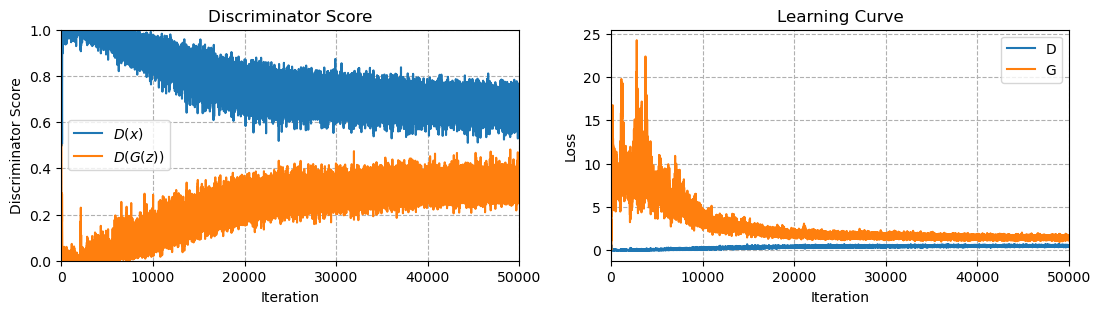

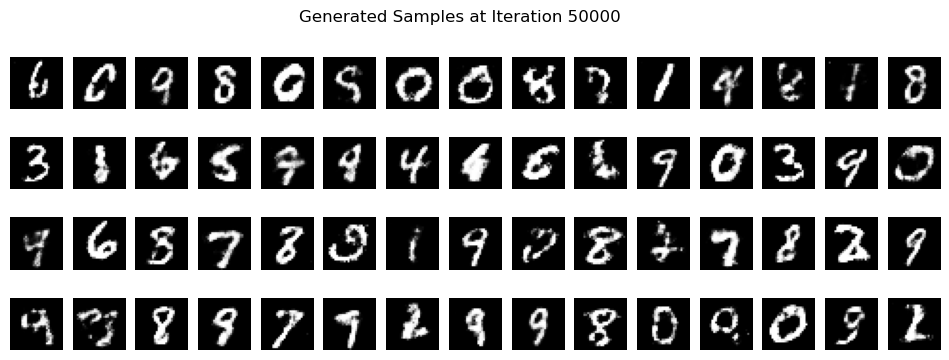

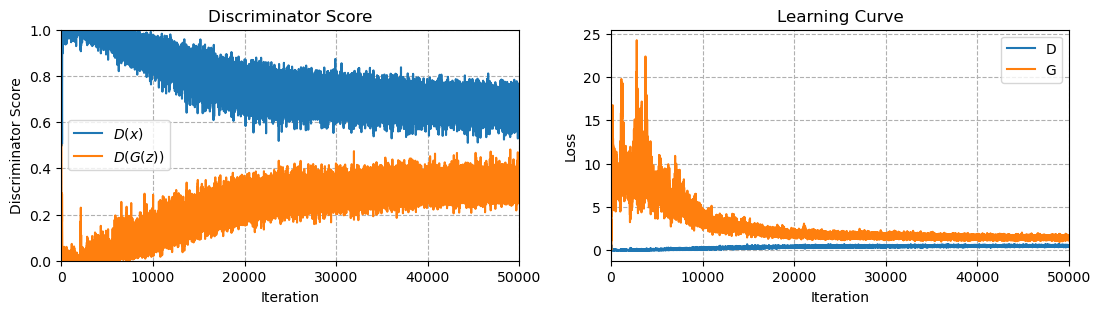

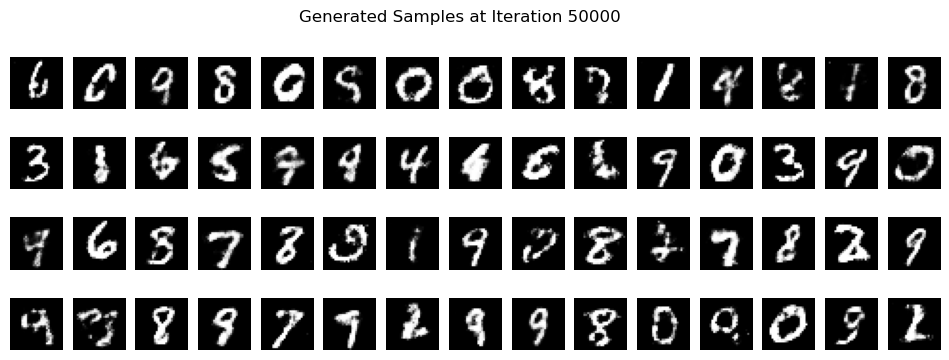

Training: 100%|██████████| 50000/50000 [12:10<00:00, 96.26iter/s]

In [8]:
if __name__ == '__main__':
    generator = Generator(**generator_config)
    discriminator = Discriminator(**discriminator_config)
    train_GAN(
        generator = generator, 
        discriminator = discriminator, 
        train_dataset = train_dataset,
        device = Device,
        plot_freq = 500,
        **train_config,
        )